In [1]:
import ROOT as rt
import uproot
import numpy as np
from collections import OrderedDict
import os
import sys
sys.path.append(os.getcwd().replace('scripts', 'lib'))

import tdrstyle
a = tdrstyle.setTDRStyle()

print(sys.version)

Welcome to JupyROOT 6.28/00
3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]


# Load ntuples
Here we will load ntuples for signal and data (high-MET skim), where the clusters are already reconstructed and stored in the ntuples. We will use these ntuples to plot some of the key variables that will used to veto background clusters

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

# load high-MET skim data
path = '/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/data/'
fpath['data'] = path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'


# load signal sample with m = 40 GeV and 4 different ctau points
path = '/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/signal/nocuts/'

mass = [40]
OLD_CTAU = np.array([1000, 10000, 100000])#in mm

for m in mass:
    for ct in OLD_CTAU:
        key = 'MC_'+str(m)+'_'+str(ct)                       
        fpath[key] = path +  'ggH_HToSSTobbbb_MH-125_MS-40_ctau-'+str(ct)+'_137000pb_weighted.root'

for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']


# Ex0 - Basic Selections and Load Branches

In [3]:
%%time

deltaPhi = {}
Nhits = {}
weight = {}
cscRechitClusterJetVeto = {}
cscRechitClusterMuonVeto = {}
cscRechitClusterTimeSpread = {}
cscRechitClusterTime = {}
cscRechitClusterEta = {}
cscRechitClusterMe1112 = {}

for k, T in tree.items():
    
    ########### SELECTION: CLUSTERS ############
    if 'data' in k:sel_clusters = T['cscRechitClusterSize'].array() > 0
    else: sel_clusters = np.logical_and(T['cscRechitCluster_match_gLLP'].array(), T['cscRechitCluster_match_gLLP_csc'].array())

    ########### SELECTION: JETS ############

    sel_jet = np.logical_and(T['jetPt'].array() > 30, np.abs(T['jetEta'].array()) < 2.4 )
    sel_jet = np.logical_and(sel_jet, T['jetTightPassId'].array())

    ########### SELECTION: EVENTS ############
    sel_ev = T['METTrigger'].array()
    sel_ev  = np.logical_and(sel_ev,np.sum(sel_clusters, axis = 1)>0)
    sel_ev = np.logical_and(sel_ev ,T['met'].array() > 200)
    sel_ev = np.logical_and(sel_ev,T['metFilters'].array())
    sel_ev = np.logical_and(sel_ev , np.sum(sel_jet,axis=1)>=1)

    #### Save variables needed ####                                   

    deltaPhi[k] = T['cscRechitClusterMet_dPhi'].array()[sel_clusters][sel_ev][:,0]
    Nhits[k] = T['cscRechitClusterSize'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterJetVeto[k] = T['cscRechitClusterJetVetoPt'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterMuonVeto[k] = T['cscRechitClusterMuonVetoPt'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterTime[k] = T['cscRechitClusterTime'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterEta[k] = T['cscRechitClusterEta'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterMe1112[k] = (T['cscRechitClusterNRechitChamberPlus11'].array() \
                                 + T['cscRechitClusterNRechitChamberMinus11'].array() \
                                 + T['cscRechitClusterNRechitChamberPlus12'].array() \
                                 + T['cscRechitClusterNRechitChamberMinus12'].array())[sel_clusters][sel_ev][:,0]
                               

    weight[k] = T['weight'].array()[sel_ev]
    print(k, np.sum(weight[k]))

data 906128.0
MC_40_1000 8391.234
MC_40_10000 5881.3994
MC_40_100000 804.09265
CPU times: user 29.1 s, sys: 7.88 s, total: 37 s
Wall time: 1min 59s


#### choose your favorite color in ROOT:  https://root.cern.ch/doc/master/classTColor.html#C01


In [4]:
std_color_list = [1,2,4,6,8] 


# Ex1 - plot jet veto and muon veto

The dominant background from the main collision comes from punch-through jets that are not fully contained in the calorimeters and high pT muons that could create bremsstrahlung showers in the muon detectors. To remove those background, we reject clusters by matching them to reconstructed jets and muon.
The pT of the jet/muon that the cluster is matched to are saved in objects called `cscRechitClusterJetVetoPt` and `cscRechitClusterMuonVetoPt`.
In this exercise you will plot the two variables for signal and background and apply a selection on the two variables to remove clusters from jets and muons.

## plot jet veto

data 0.28715479490756274
MC_40_1000 0.8002997809293209
MC_40_10000 0.866107436683336
MC_40_100000 0.8695652173913043


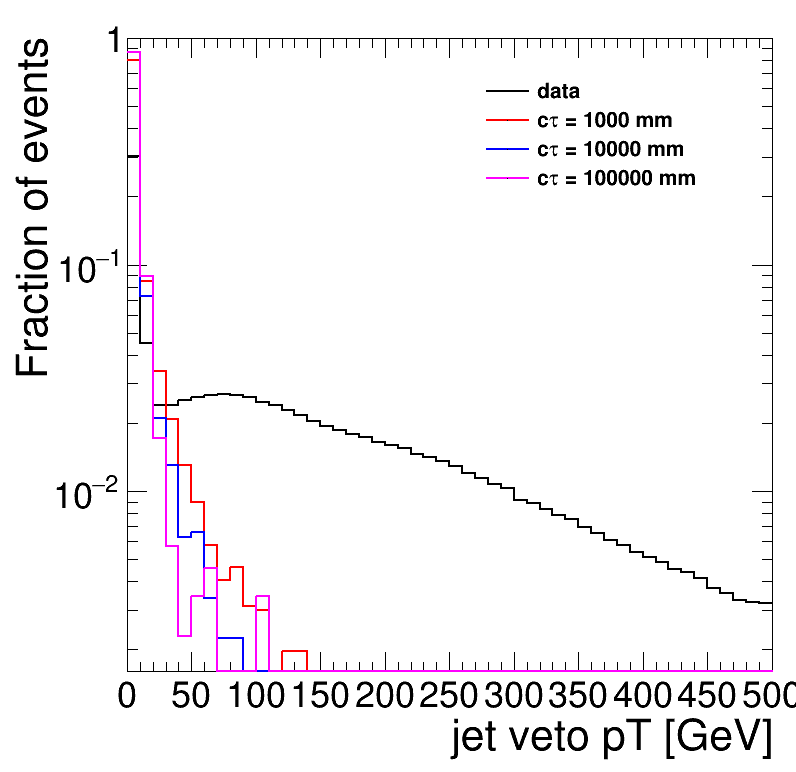

In [5]:
leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 500)
    h[k].SetXTitle('jet veto pT [GeV]')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterJetVeto[k])): h[k].Fill(cscRechitClusterJetVeto[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterJetVeto[k]<10)/len(cscRechitClusterJetVeto[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

## plot muon veto

data 0.5921238500520898
MC_40_1000 0.9334716937622507
MC_40_10000 0.9391837393127924
MC_40_100000 0.9427917620137299


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


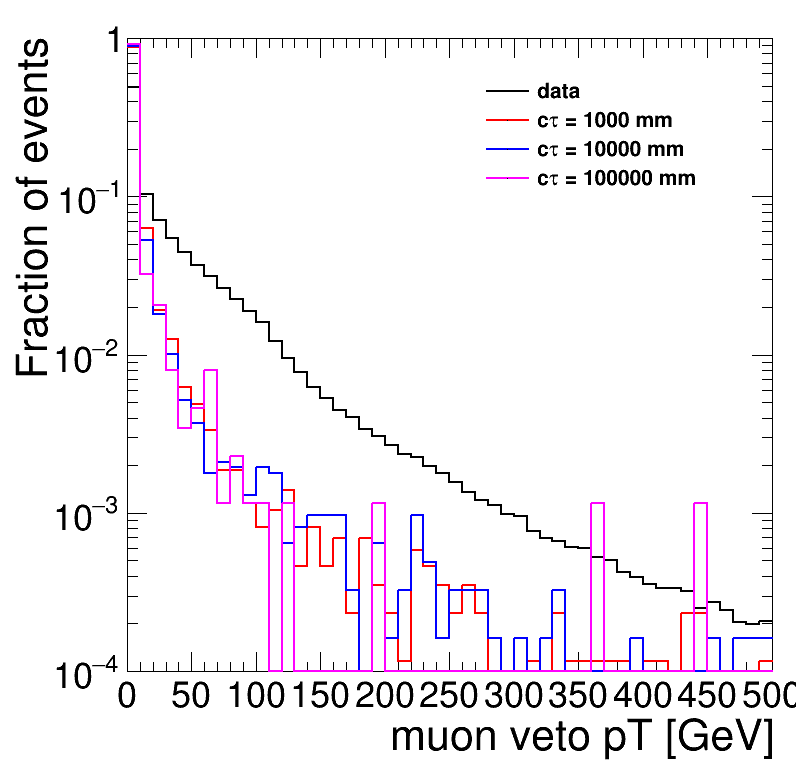

In [6]:
leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 500)
    h[k].SetXTitle('muon veto pT [GeV]')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterMuonVeto[k])): h[k].Fill(cscRechitClusterMuonVeto[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterMuonVeto[k]<20)/len(cscRechitClusterMuonVeto[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# Ex2 - plot number of ME11 and ME12 hits in the cluster

Additionally, punch-through jets or muon bremsstrahlung showers might not get reconstructed as jets and muons.
To fully remove these background, we remove clusters that have hits in the first CSC stations (ME11/ME12) that have little shielding in front.

In this exercise you will plot the number of ME11/ME12 hits in clusters for signal and background and apply a selection on the two variables to remove clusters from jets and muons.

## plot number of ME11 and ME12 hits in cluster

data 0.03034118799992937
MC_40_1000 0.48864291479303584
MC_40_10000 0.5810614615260525
MC_40_100000 0.5949656750572082
CPU times: user 1min 3s, sys: 187 ms, total: 1min 3s
Wall time: 1min 3s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


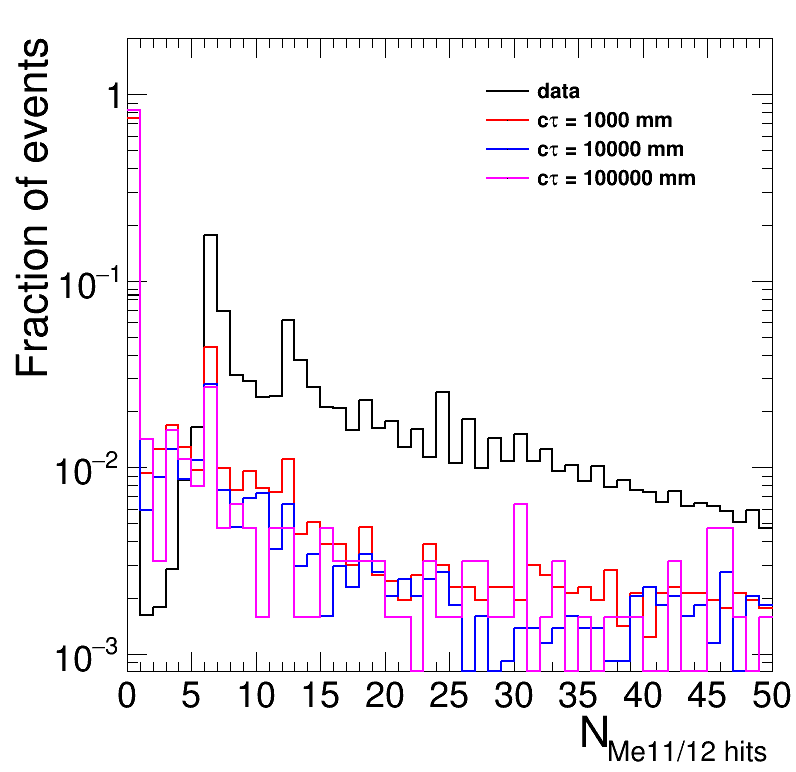

In [16]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 50)
    h[k].SetXTitle('N_{Me11/12 hits}')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterMe1112[k])): h[k].Fill(cscRechitClusterMe1112[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterMe1112[k]==0)/len(cscRechitClusterMe1112[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(2)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# Ex3 - plot cluster eta

After we removed punch-through jets and muon brems, we observed that there are a lot more backgorund in higer $\eta$ region, where the muon reconstruction efficiency is lower and more pileup particles are present to create clusters.

In this exercise you will plot the cluster $\eta$ for signal and background and apply a selection on the variable to remove clusters from high $\eta$ region.

data 0.5188218441544682
MC_40_1000 0.8732849071832123
MC_40_10000 0.9122439103081142
MC_40_100000 0.9210526315789473
CPU times: user 1min 4s, sys: 169 ms, total: 1min 4s
Wall time: 1min 4s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


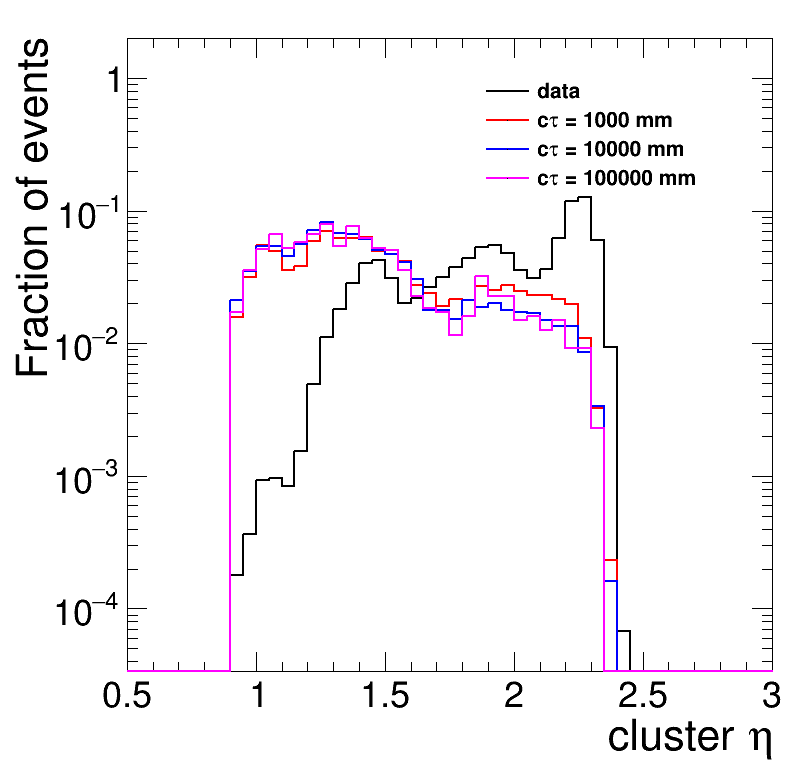

In [12]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0.5, 3)
    h[k].SetXTitle('cluster #eta')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterEta[k])): h[k].Fill(abs(cscRechitClusterEta[k][j]))

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(np.abs(cscRechitClusterEta[k])<2)/len(cscRechitClusterEta[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(2)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# Ex4 - plot cluster time (after vetos are applied)

The remaining background clusters after punch-through jet and muon brem showers from the main collision are removed, are from low pT particles in pileup events.
To verify this, you will plot the cluster time for signal and background, after applying the vetoes, in this exercise to check for any out-of-time pileup contributions in data.


data 0.29137863204631037
MC_40_1000 0.9998219373219374
MC_40_10000 0.9689333043667173
MC_40_100000 0.9192073170731707
CPU times: user 5.7 s, sys: 31.1 ms, total: 5.73 s
Wall time: 5.72 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


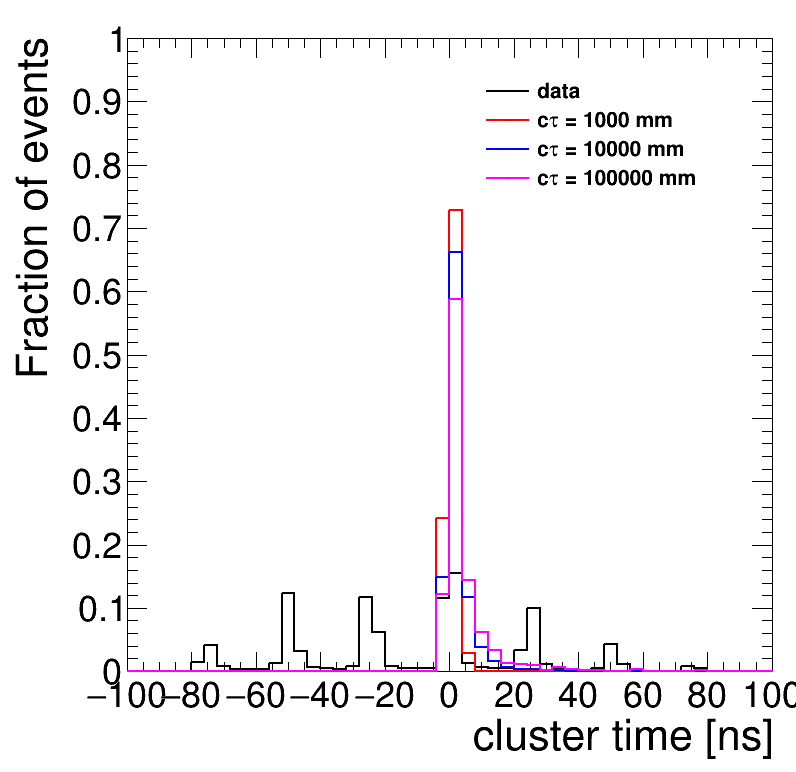

In [13]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, -100, 100)
    h[k].SetXTitle('cluster time [ns]')
    h[k].SetYTitle('Fraction of events')
    
    sel = np.logical_and(cscRechitClusterJetVeto[k]<10, cscRechitClusterMuonVeto[k]<20)
    sel = np.logical_and(sel, np.abs(cscRechitClusterEta[k])<2)
    
    time_temp = cscRechitClusterTime[k][sel]
    for j in range(len(time_temp)): h[k].Fill(time_temp[j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(np.logical_and(time_temp<12.5, time_temp>-5))/len(time_temp))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')

leg.Draw()
c.SetRightMargin(0.03)
c.Draw()

# Ex5 - plot $\Delta\phi\mathrm{(cluster, MET)}$ and $N_{hits}$ in Out-of-time Validation Region (final discriminating variables)


The final discriminating variables that we will use to extract the signal and estimate background are the number of hits in the cluster ($N_{\text{hits}}$) and the azimuthal angle between the cluster and MET ( $\Delta\phi\text{(cluster, MET)}$).
The background estimation method will be described in more detail in the next episode.
In this exercise, we will just plot the distributions of the two variables, to understand the shape of the two variables.

## plot $N_{hits}$

data 0.051152936841782064
MC_40_1000 0.8823005698005698
MC_40_10000 0.8138170758201173
MC_40_100000 0.7820121951219512
CPU times: user 3.05 s, sys: 8.08 ms, total: 3.05 s
Wall time: 3.05 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


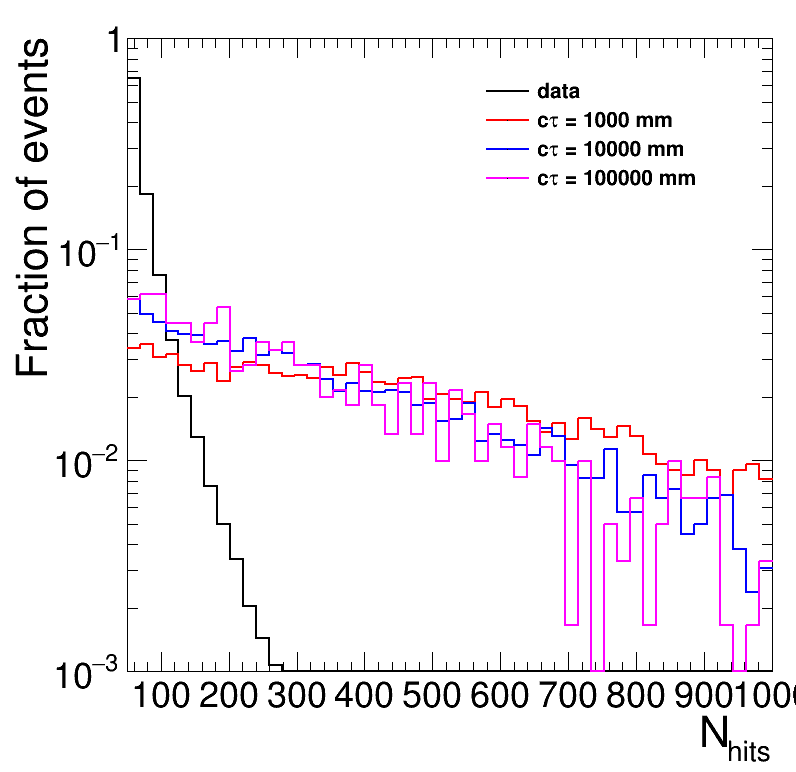

In [14]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 50, 1000)
    h[k].SetXTitle('N_{hits}')
    h[k].SetYTitle('Fraction of events')
    
    sel = np.logical_and(cscRechitClusterJetVeto[k]<10, cscRechitClusterMuonVeto[k]<20)
    sel = np.logical_and(sel, np.abs(cscRechitClusterEta[k])<2)
    if 'data' in k: sel = np.logical_and(sel, cscRechitClusterTime[k]<-12.5)
    nhits_temp = Nhits[k][sel]
    for j in range(len(nhits_temp)): h[k].Fill(nhits_temp[j])
        
    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(nhits_temp>130)/len(nhits_temp))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    h[k].SetMinimum(1e-3)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')

leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

## plot $\Delta\phi\mathrm{(cluster, MET)}$

data 0.2332586201602751
MC_40_1000 0.9902065527065527
MC_40_10000 0.9463393439061482
MC_40_100000 0.9359756097560976
CPU times: user 3.06 s, sys: 14.1 ms, total: 3.08 s
Wall time: 3.07 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


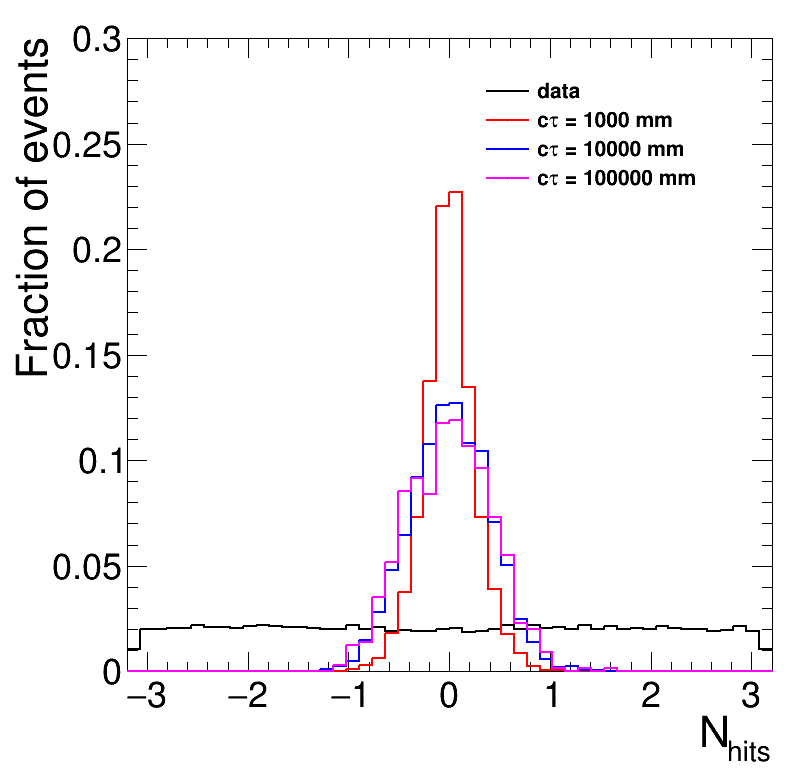

In [15]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
   
        
    h[k] = rt.TH1D('', '', 50, -3.2,3.2)
    h[k].SetXTitle('N_{hits}')
    h[k].SetYTitle('Fraction of events')
    
    sel = np.logical_and(cscRechitClusterJetVeto[k]<10, cscRechitClusterMuonVeto[k]<20)
    sel = np.logical_and(sel, np.abs(cscRechitClusterEta[k])<2)
    if 'data' in k: sel = np.logical_and(sel, cscRechitClusterTime[k]<-12.5)
    dphi_temp = deltaPhi[k][sel]
    for j in range(len(dphi_temp)): h[k].Fill(dphi_temp[j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(np.abs(dphi_temp)<0.75)/len(dphi_temp))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(0.3)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')

leg.Draw()
c.SetRightMargin(0.03)
c.Draw()